In [1]:
import gzip
import json
import os
import glob
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt, find_peaks
import torch
from torchvision.ops import box_iou
from detectron2.structures import BoxMode

In [2]:
trace_files = sorted(
    glob.glob(
        "/scratch/shared/beegfs/prannay/ego4d_data/ckpt/results/traces_v2/vq_stats_val_*.json.gz"),
    key=lambda x: int(x.split("_")[-1].split(".")[0])
)

In [3]:
def preprocess_data(data):
    data = data['predictions']
    # convert generic Dict[List] to List[Dict]
    out_list = []
    keys = sorted(data.keys())
    for idx in range(len(data[keys[0]])):
        save_dict = {k: data[k][idx] for k in keys}
        out_list.append(save_dict)
    return out_list

annotation_export = []
for file_path in tqdm(trace_files, total=len(trace_files)):
    with gzip.open(file_path, "rt") as f:
        data = json.load(f)
        annotation_export += preprocess_data(data)

  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
annotation_export = sorted(annotation_export, key=lambda x: x["dataset_uids"])

In [5]:
with open("../data/val_annot.json", "r") as f:
    raw_annotations = json.load(f)

In [6]:
raw_annotations[0]['response_track']

[{'frame_number': 1292,
  'x': 1.1,
  'y': 1007.51,
  'width': 116.43,
  'height': 70.69,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1080,
  'video_frame_number': 7752},
 {'frame_number': 1293,
  'x': -0.23,
  'y': 926.14,
  'width': 126.4,
  'height': 153.53,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1080,
  'video_frame_number': 7758},
 {'frame_number': 1294,
  'x': -1.38,
  'y': 881.55,
  'width': 82.32,
  'height': 197.79,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1080,
  'video_frame_number': 7764},
 {'frame_number': 1295,
  'x': -0.23,
  'y': 811.81,
  'width': 81.18,
  'height': 267.54,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1080,
  'video_frame_number': 7770},
 {'frame_number': 1296,
  'x': 2.05,
  'y': 784.37,
  'width': 85.75,
  'height': 292.69,
  'rotation': 0,
  'original_width': 1920,
  'original_height': 1080,
  'video_frame_number': 7776},
 {'frame_number': 1297,
  'x': 2.05,
  'y'

In [7]:
raw_annotations[0].keys()

dict_keys(['metadata', 'clip_uid', 'query_set', 'query_frame', 'response_track', 'visual_crop', 'object_title', 'dataset_uid'])

In [8]:
raw_annot_metadata = {a['dataset_uid']: a for a in raw_annotations}

In [9]:
annotation_export_dict = {a['dataset_uids']: a for a in annotation_export}

In [10]:
import pickle
with open("../../dinov2/notebooks/peak_results.pkl", "rb") as fp:
    peak_results = pickle.load(fp)

In [11]:
for k, v in peak_results.items():
    if len(v):
        # print(k, v.keys())
        # print(len(annotation_export_dict[k]['predicted_bboxes']))
        if len(v['scores']) == len(annotation_export_dict[k]['predicted_bboxes']):
            # add v to annotation_export_dict
            for k1, v1 in v.items():
                annotation_export_dict[k][k1] = v1


In [12]:
set([len(v) for v in annotation_export_dict.values()])

{10, 14}

In [13]:
inputs = [(video_data, raw_annot_metadata[video_data['dataset_uids']],) for video_data in annotation_export]

In [14]:
total_valid_peaks = defaultdict(set)
for video_data, annot_data in inputs:
    if annot_data['clip_uid'] is not None:
        total_valid_peaks[annot_data['clip_uid']].update(video_data['predicted_peaks'])

In [15]:
sum(len(v) for v in total_valid_peaks.values())

133002

In [16]:
annotation_export[-1]['dataset_uids']

'val_0000004506'

In [17]:
len(annotation_export)

4507

In [18]:
# annotation_export[0]['predicted_trace_fnos']

In [19]:
data_all = defaultdict(list)

In [20]:
for file_path in tqdm(trace_files, total=len(trace_files)):
    with gzip.open(file_path, "rt") as fp:
        data = json.load(fp)
        for k, v in data['predictions'].items():
            data_all[k].extend(v)

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
data['predictions'].keys()

dict_keys(['predicted_scores', 'predicted_bboxes', 'predicted_peaks', 'groundtruth_response_tracks', 'visual_crop', 'dataset_uids', 'predicted_trace_scores', 'predicted_trace_fnos'])

In [22]:
# for k, v in data_all.items():
# print(k, type(v))

In [23]:
data_all.keys()

dict_keys(['predicted_scores', 'predicted_bboxes', 'predicted_peaks', 'groundtruth_response_tracks', 'visual_crop', 'dataset_uids', 'predicted_trace_scores', 'predicted_trace_fnos'])

In [14]:
def get_med_scores(scores):
    scores = np.array(scores)
    scores = medfilt(scores, kernel_size=5)
    return scores

In [38]:
query_duid = "val_0000000002"

In [41]:
def plot_results(data):
    fnos = data['predicted_trace_fnos']
    peaks = data['predicted_peaks']
    # print(data['predicted_trace_scores'])
    scores = get_med_scores(data['predicted_trace_scores'])
    # scores = np.concatenate([[0.0], scores,])
    # print(data.keys())
    # scores_dinov2 = data['scores_dinov2']
    # scores_dino = data['scores_vits16']
    #   smoothing_sigma: 5
    #   distance: 25
    #   width: 3
    #   prominence: 0.2
    peaks_new = find_peaks(
        scores,
        height=0.1,
        distance=3,
        prominence=0.0,
        width=1,
    )
    print(len(peaks_new[0]))
    print(len(peaks))

        
    # print(scores)
    # print(peaks)
    peak_scores = scores[peaks]
    gt_rt = data['groundtruth_response_tracks']
    gt_fnos = {x['frame_number'] for x in gt_rt}
    gt_scores = [(1.0 if i in gt_fnos else 0.0) for i in fnos]
    # get bool if there is a peak in the gt_fnos
    # print(any([x in gt_fnos for x in peaks]))
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(fnos, scores, lw=2)
    ax.plot(peaks_new[0], scores[peaks_new[0]], 'o', label="new score")
    ax.plot(peaks, peak_scores, 'x', label="raw model score", ms=10)
    # ax.plot(peaks, scores_dinov2, 'o', label="dinov2 score")
    # ax.plot(peaks, scores_dinov2, '+', label="dinov1 score")
    ax.plot(fnos, gt_scores, lw=2, color='red')
    plt.show()
    plt.close()

0
0


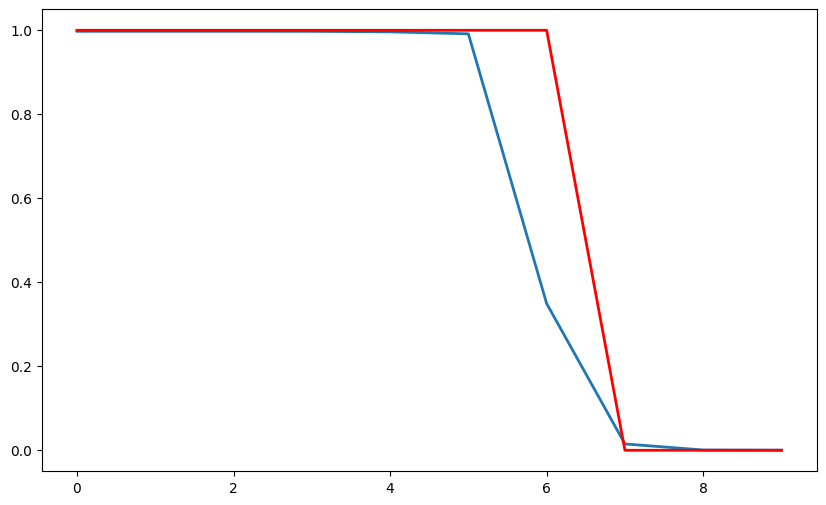

In [42]:
plot_results(annotation_export_dict[query_duid])

In [214]:
scores_dinov2_all = []
scores_raw_all = []
for k, v in annotation_export_dict.items():
    if "scores_dinov2" in v:
        scores_dinov2_all.extend(v['scores_dinov2'])
    

    plot_results(annotation_export_dict[k])

SyntaxError: invalid syntax (2386544324.py, line 2)

33940


In [88]:
def check_recent_peak(data_all, score_thresh=0.6):
    correct_all = defaultdict(list)
    for k, duid in tqdm(enumerate(data_all['dataset_uids']), total=len(data_all['dataset_uids'])):
        fnos = data_all['predicted_trace_fnos'][k]
        peaks = data_all['predicted_peaks'][k]
        if len(peaks) == 0:
            # print("No peaks found")
            # print(data_all['dataset_uids'][k])
            correct_all[-2].append(duid)
            continue
        scores = get_med_scores(data_all['predicted_trace_scores'][k])
        # print(scores)
        # print(peaks)
        peak_scores = scores[peaks]
        # print(peak_scores)
        gt_rt = data_all['groundtruth_response_tracks'][k]
        gt_fnos = {x['frame_number'] for x in gt_rt}

        # get the last peak with score over score_thresh
        last_peak = [x for i, x in enumerate(peaks) if peak_scores[i] >= score_thresh]
        # print(len(last_peak), last_peak)
        # print(len(peaks), peaks)
        if len(last_peak) == 0:
            # print("No peaks above threshold")
            # print(data_all['dataset_uids'][k])
            correct_all[-1].append(duid)
            continue
        last_peak = last_peak[-1]
        correct = 0 if last_peak in gt_fnos else 2 if last_peak > max(gt_fnos) else 1 if last_peak < min(gt_fnos) else -10
        correct_all[correct].append(duid)
        # break
    return correct_all

In [89]:
corrects_overall = defaultdict(list)
for sc in (score_thresholds := np.arange(0.1, 0.65, 0.1)):
    corrects = check_recent_peak(data_all, score_thresh=sc)
    for k in [-2, -1, 0, 1, 2]:
        corrects_overall[k].append(len(corrects[k])/len(data_all['dataset_uids']))
    # for k, v in corrects.items():
    #     print(k, len(v), len(v)/len(data_all['dataset_uids']))

  0%|          | 0/4507 [00:00<?, ?it/s]

  0%|          | 0/4507 [00:00<?, ?it/s]

  0%|          | 0/4507 [00:00<?, ?it/s]

  0%|          | 0/4507 [00:00<?, ?it/s]

  0%|          | 0/4507 [00:00<?, ?it/s]

  0%|          | 0/4507 [00:00<?, ?it/s]

In [91]:
corrects[1]

['val_0000000002',
 'val_0000000010',
 'val_0000000011',
 'val_0000000016',
 'val_0000000018',
 'val_0000000025',
 'val_0000000028',
 'val_0000000029',
 'val_0000000031',
 'val_0000000035',
 'val_0000000039',
 'val_0000000047',
 'val_0000000049',
 'val_0000000050',
 'val_0000000051',
 'val_0000000067',
 'val_0000000069',
 'val_0000000071',
 'val_0000000072',
 'val_0000000073',
 'val_0000000074',
 'val_0000000075',
 'val_0000000076',
 'val_0000000077',
 'val_0000000079',
 'val_0000000081',
 'val_0000000083',
 'val_0000000084',
 'val_0000000085',
 'val_0000000090',
 'val_0000000094',
 'val_0000000095',
 'val_0000000099',
 'val_0000000103',
 'val_0000000112',
 'val_0000000113',
 'val_0000000116',
 'val_0000000117',
 'val_0000000120',
 'val_0000000123',
 'val_0000000124',
 'val_0000000126',
 'val_0000000134',
 'val_0000000136',
 'val_0000000137',
 'val_0000000139',
 'val_0000000141',
 'val_0000000142',
 'val_0000000143',
 'val_0000000149',
 'val_0000000150',
 'val_0000000151',
 'val_000000

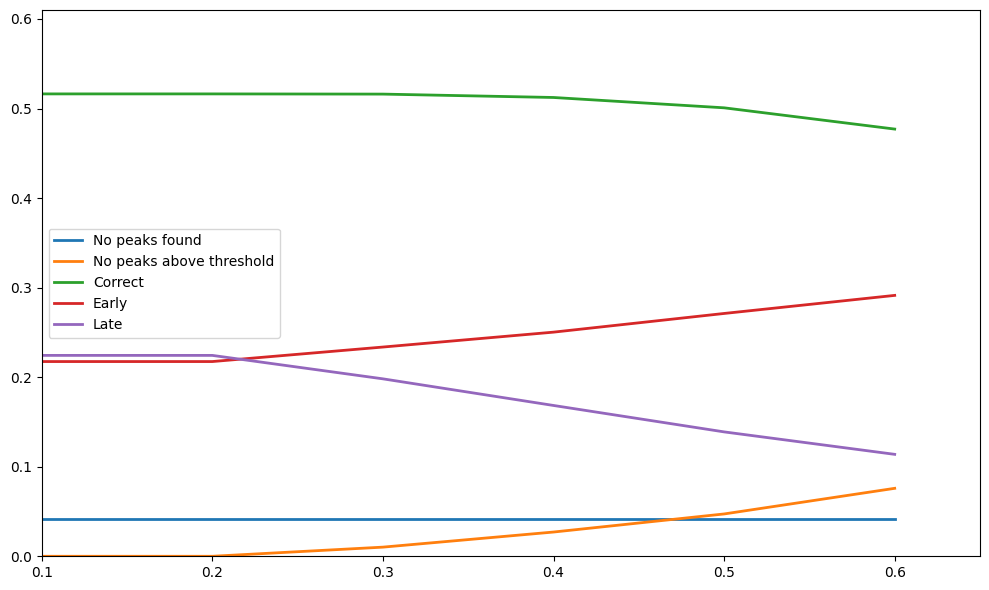

0.4770357222098957


In [69]:
# let us plot as a function of score threshold
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
legend_keys = {
    -1: "No peaks above threshold",
    -2: "No peaks found",
    0: "Correct",
    1: "Early",
    2: "Late"
}
for k, v in corrects_overall.items():
    ax.plot(score_thresholds, v, label=legend_keys[k], lw=2)
ax.legend()
ax.set_ylim([-0.0, 0.61])
ax.set_xlim([0.1, 0.65])
plt.tight_layout()
plt.show()
print(corrects_overall[0][-1])

In [21]:
corrects_overall

defaultdict(list,
            {0: [2327, 2327, 2326, 2309, 2257, 2150, 2026, 1829, 1442],
             1: [980, 980, 1053, 1128, 1222, 1313, 1406, 1423, 1442],
             2: [1011, 1011, 893, 759, 626, 513, 390, 301, 175],
             -2: [189, 189, 189, 189, 189, 189, 189, 189, 189],
             -1: [46, 122, 213, 342, 496, 765, 1259]})

In [169]:
def get_iou(pred_bboxes, gt_bbox):
    pred_bbox = torch.tensor([[pred_bbox['x1'], pred_bbox['y1'], pred_bbox['x2'], pred_bbox['y2']] for pred_bbox in pred_bboxes])
    gt_bbox = torch.tensor([gt_bbox['x'], gt_bbox['y'], gt_bbox['width'], gt_bbox['height']]).unsqueeze(0)
    gt_bbox = BoxMode.convert(gt_bbox, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
    return box_iou(pred_bbox, gt_bbox).max()

def check_gt_window_once(data_all, k, top_k=10):
    # print(data_all.keys())
    fnos = np.array(data_all['predicted_trace_fnos'][k])
    peaks = np.array(data_all['predicted_peaks'][k])
    if len(peaks) == 0:
        return -1
    scores = np.array(data_all['predicted_trace_scores'][k])
    peak_scores = scores[peaks]
    gt_rt = data_all['groundtruth_response_tracks'][k]
    gt_fnos = np.array([x['frame_number'] for x in gt_rt])
    # print(gt_fnos)
    gt_idxs = (gt_fnos.reshape(-1, 1) == fnos.reshape(1, -1)).argmax(axis=1)
    gt_peaks_idxs = [i for i, x in enumerate(peaks) if x in gt_fnos]
    gt_peaks_idxs2 = [i for i, x in enumerate(gt_fnos) if x in peaks]
    if len(gt_peaks_idxs) == 0:
        return -1
    # print(peaks[gt_peaks_idxs])
    # print(len(data_all['predicted_bboxes'][k]))
    boxes = np.array(data_all['predicted_bboxes'][k])
    # print(boxes[gt_peaks_idxs, 0])
    # print([gt_rt[i] for i in gt_peaks_idxs2])
    
    # print(peak_scores[gt_peaks_idxs])
    # lets get iou of each peak with the gt
    ious = []
    for i, j in zip(gt_peaks_idxs, gt_peaks_idxs2):
        ious.append(get_iou(boxes[i, :top_k], gt_rt[j]))
    
    relevant_peak_scores = peak_scores[gt_peaks_idxs].tolist()
    return sorted([(x, y) for x, y in zip(ious, relevant_peak_scores)], reverse=True, key=lambda x: x[1])
    # return sorted(ious, reverse=True, key=peak_scores[gt_peaks_idxs].tolist())
    # get bool if there is a peak in the gt_fnos
    # print(any([x in gt_fnos for x in peaks]))
    # print(peak

def check_gt_window(data_all, top_k=1):
    ious = []
    for k in tqdm(range(len(data_all['dataset_uids']))):
        iou = check_gt_window_once(data_all, k, top_k=top_k)
        if isinstance(iou, int):
            continue
        ious.append([x[0] for x in iou])
    return ious


In [170]:
for top_k in [1, 2, 5, 10, 20, 50, 100, 128]:
    ious = check_gt_window(data_all, top_k=top_k)
    print([np.mean([x[0] >= thresh for x in ious]) for thresh in [0.3, 0.5, 0.75]])

  0%|          | 0/4507 [00:00<?, ?it/s]

[0.8813978115072362, 0.8115072361454289, 0.4980585951288387]


  0%|          | 0/4507 [00:00<?, ?it/s]

[0.9184609954112248, 0.8644546417225556, 0.5273561595481822]


  0%|          | 0/4507 [00:00<?, ?it/s]

[0.9428168019767031, 0.8983409812919168, 0.5407695022943876]


  0%|          | 0/4507 [00:00<?, ?it/s]

[0.9516413695728909, 0.9092834451111895, 0.5446523120367102]


  0%|          | 0/4507 [00:00<?, ?it/s]

[0.9597599717613837, 0.9163430991881398, 0.5453582774444052]


  0%|          | 0/4507 [00:00<?, ?it/s]

[0.9636427815037063, 0.92340275326509, 0.5474761736674902]


  0%|          | 0/4507 [00:00<?, ?it/s]

[0.9742322626191317, 0.9322273208612778, 0.5488881044828804]


  0%|          | 0/4507 [00:00<?, ?it/s]

[0.9777620896576068, 0.937169078715143, 0.5499470525944229]


0.8813978115072362
